In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# Remember to update your path
import sys
sys.path.append('/home/rz14/Documents/QR_Qishi/QishiQR/')

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from Utils.IOUtils import *
from Utils.lm import *
from Backtesting.Vectorized.Strategy import MovingAverageStrategy, SLMStrategy
from Backtesting.Vectorized.backtest import vectorizedbacktest
from Backtesting.Vectorized.cross_compare import ensembler

# ====== Initial Configuration ========
ROOT_DIR = "/home/rz14/Documents/QR_Qishi/QishiQR/Backtesting/"
DATA_DIR = "tests"
ASSET = "Ag"
OUTPUT_DIR = "Output"
# =====================================

# Build DATA_PATH with Python Pathlib -- More organized than simple strings with OS library
# https://www.scivision.co/python-idiomatic-pathlib-use/

DATA_PATH = Path(ROOT_DIR, DATA_DIR)
ASSET_PATH = Path(ROOT_DIR,OUTPUT_DIR, ASSET)
ASSET_PATH.mkdir(exist_ok=True, parents=True)

%load_ext autoreload
%autoreload 2
%matplotlib inline

# SLM model: Single-Order

### Import data and the probability table

In [2]:
data = pd.read_csv(DATA_PATH/'ag_1712_5min.csv')  # The '/' operator is from Pathlib.
slm = pd.read_csv(DATA_PATH/'ag_5min_freq.csv')[['prior', 'max']]
slm = slm.rename(columns={'max': 'signal'})

### Generate signals

In [3]:
signals = SLMStrategy(data, slm,2).generatingsignal()
signals['match'] = signals.apply(lambda row: 1 if row['signal'] == row['Direction'] else 0, axis=1)
signals.to_csv(str(ASSET_PATH/'ag_5min_signal.csv'), index=False)

### Run backtest

In [4]:
#tca: trading cost to be applied
test = vectorizedbacktest(signals, tca = 'None')
returns = test.runtest()
test.calperformance()
test.performance

{'Annualized Volatility': 0.11280587736749559,
 'Average Daily Return': 0.004229505571314624,
 'Average Negative Return': -0.0011132006319265072,
 'Average Positive Return': 0.0013145274650836198,
 'Average Return per Trade': 0.00019606979469670446,
 'Largest Losing Trade': -0.0057831486480913455,
 'Largest Winning Trade': 0.017552864117196344,
 'Max Drawdown': -0.008142270450427369,
 'Profit Factor': 1.1808540413857798,
 'Sharpe Ratio': 9.373415796270676,
 'Total Number of Trades': 302,
 'Total Return': 1.0592130779984048,
 'Winning Rate': 0.2781456953642384}

# SLM Model: Multiple Order Comparison

### Generate signals with different orders

In [5]:
def compile_signal(DATA_PATH, max_order=6):
    data = pd.read_csv(DATA_PATH / 'ag_1712_5min.csv')
    slm = pd.read_csv(DATA_PATH / 'ag_5min_freq.csv')[['prior', 'max']]
    slm = slm.rename(columns={'max': 'signal'})
    signals = [SLMStrategy(data, slm, m).generatingsignal() for m in np.arange(1, max_order+1)]
    return signals

signals = compile_signal(DATA_PATH, max_order=6)

### Preparing backtests with all signals

In [6]:
tester_ensemble = ensembler(vectorizedbacktest, signals)
tester_ensemble.build()
tester_ensemble.run()

print(len(tester_ensemble.results))

6


### Calculate the performance

In [7]:
tester_ensemble.calperformance()

### Plot

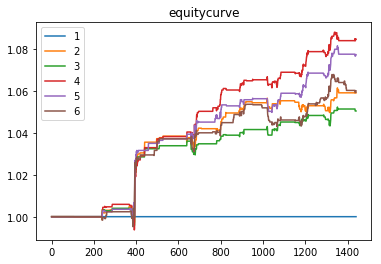

In [8]:
tester_ensemble.plot()

In [9]:
tester_ensemble.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
Model Order,,,,,,,,,,,,,
1,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1,1.000000,0.000000
2,0.112806,0.004230,-0.001113,0.001315,0.000196,-0.005783,0.017553,-0.008142,1.180854,9.373416,302,1.059213,0.278146
3,0.100453,0.003609,-0.001178,0.001408,0.000263,-0.005783,0.017553,-0.008378,1.194875,8.982423,192,1.050530,0.317708
4,0.112160,0.006061,-0.001071,0.001347,0.000357,-0.005783,0.017553,-0.012157,1.258102,13.510609,238,1.084860,0.394958
5,0.124873,0.005532,-0.001033,0.001397,0.000332,-0.005783,0.017553,-0.006465,1.352311,11.075093,233,1.077447,0.364807
6,0.128478,0.004295,-0.001101,0.001368,0.000179,-0.004113,0.017553,-0.010102,1.243065,8.357164,336,1.060128,0.264881


# LM Model

In [184]:
DATA_ROOT = Path('/home/rz14/Documents/QR_Qishi/tick2016')
OUTPUT_DIR = Path('/home/rz14/Documents/QR_Qishi/QishiQR/Output')
slm = LM_model(data_root_dir=str(DATA_ROOT),n=8)

In [185]:
offset = np.linspace(0,5,5, endpoint=False)
word_prob_tables = [slm.LM(commodity='ag', exp_list=['1701'], offset=x) for x in offset]

============ag train============
----------Running:1701----------
============ag train============
----------Running:1701----------
============ag train============
----------Running:1701----------
============ag train============
----------Running:1701----------
============ag train============
----------Running:1701----------


In [190]:
import pickle
pickle.dump(word_prob_tables, open('word_prob_tables.p','wb'))

In [196]:
merged_tables = pd.concat(word_prob_tables, axis=1,keys=offset, names=['offset'])
merged_tables = merged_tables.loc[:,(slice(None),'max')]
merged_tables.columns = merged_tables.columns.droplevel(1)

In [198]:
merged_tables.head(5)

offset,0.0,1.0,2.0,3.0,4.0
prior,,,,,
,0,0,0,0,0
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
00,0,0,0,0,0


In [127]:
merged_tables['mean'] = merged_tables[offset].mean(axis=1)
merged_tables['std'] = merged_tables.std(axis=1)

In [128]:
merged_tables.head(n=10)

offset,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,mean,std
prior,,,,,,,,,,,,,
,0.934835,0.932318,0.932000,0.932714,0.933508,0.933270,0.932873,0.933191,0.933746,0.933111,0.933265,0.933166,0.000715
0,0.945024,0.944506,0.944061,0.943934,0.944407,0.944307,0.944454,0.943963,0.943996,0.944043,0.944303,0.944272,0.000310
1,0.812500,0.800959,0.797647,0.832134,0.813559,0.790865,0.785714,0.807143,0.810096,0.789598,0.798077,0.803481,0.012786
2,0.765258,0.729358,0.736111,0.723898,0.748235,0.767059,0.758216,0.758294,0.768496,0.771429,0.760000,0.753305,0.015796
00,0.951108,0.950523,0.950663,0.950153,0.950311,0.950563,0.950549,0.950721,0.950302,0.950450,0.950648,0.950545,0.000243
01,0.828660,0.816456,0.815625,0.857143,0.836478,0.800633,0.810726,0.823529,0.820755,0.803738,0.817610,0.821032,0.015047
02,0.772595,0.741071,0.750742,0.729970,0.744048,0.758112,0.758929,0.767857,0.777126,0.786350,0.768546,0.759577,0.016192
10,0.866864,0.862275,0.846608,0.841499,0.845238,0.844985,0.842424,0.840708,0.857567,0.868263,0.876506,0.853903,0.012196
11,0.676471,0.750000,0.720930,0.727273,0.800000,0.765957,0.770833,0.725000,0.750000,0.674419,0.621622,0.725682,0.048869


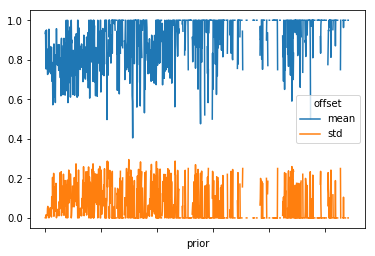

In [135]:
merged_tables[['mean','std']].plot()

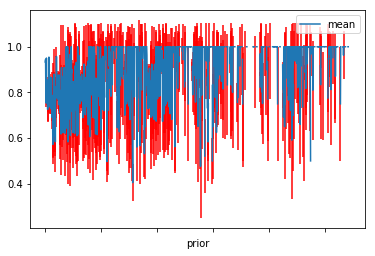

In [141]:
merged_tables.plot(y='mean',yerr='std',ecolor='red')

In [142]:
slm.run(commodity='ag')

0.0min
============ag train============
----------Running:1701----------
0.5min
============ag train============
----------Running:1701----------
1.0min
============ag train============
----------Running:1701----------
1.5min
============ag train============
----------Running:1701----------
2.0min
============ag train============
----------Running:1701----------
2.5min
============ag train============
----------Running:1701----------
3.0min
============ag train============
----------Running:1701----------
3.5min
============ag train============
----------Running:1701----------
4.0min
============ag train============
----------Running:1701----------
4.5min
============ag train============
----------Running:1701----------
0.0min
============ag valid============
----------Running:1701----------
0.5min
============ag valid============
----------Running:1701----------
1.0min
============ag valid============
----------Running:1701----------
1.5min
============ag valid============
----------R

move,max_train_mean,max_valid_mean,max_train_std,max_valid_std,max_train,t_score_train,dof,t_score,pvalue_train,pvalue_cx
prior,,,,,,,,,,
p,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,NaN
p0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,NaN
p00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,NaN
p000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,NaN
p0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,NaN
p00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,NaN
p000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,NaN
p000001,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,NaN
p000002,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,NaN
